In [ ]:
!pip install sqlalchemy langgraph langchain langchain_aws langchain_community mypy_boto3_bedrock_runtime tavily-python langchain_fireworks langchain_together aiomysql flask-ngrok pyngrok


In [ ]:
import os


In [ ]:
import boto3

def get_bedrock_client():
    session = boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=os.environ["AWS_DEFAULT_REGION"]
    )
    client = session.client("bedrock-runtime")
    return client

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Optional
import operator
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_aws.chat_models import ChatBedrock
from langchain_core.callbacks import StreamingStdOutCallbackHandler
from mypy_boto3_bedrock_runtime.client import BedrockRuntimeClient
from pydantic import BaseModel, Field , RootModel
from enum import Enum
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from tavily import TavilyClient
from typing import List,Union

In [ ]:
import logging
import sqlalchemy.engine

logging.getLogger("sqlalchemy.engine").setLevel(logging.WARNING)


In [ ]:
class ModelKwargs(BaseModel):
    temperature: float = Field(default=0.1, ge=0, le=1)
    max_tokens: int = Field(default=2048, ge=1, le=4096)
    top_p: float = Field(default=0.999, ge=0, le=1)
    top_k: int = Field(default=0, ge=0, le=500)

class ModelKwargsMeta(BaseModel):
    temperature: float = Field(default=0.1, ge=0, le=1)
    max_tokens: int = Field(default=2048, ge=1, le=4096)
    top_p: float = Field(default=0.999, ge=0, le=1)

class ModelId(str, Enum):
    CLAUDE_3_HAIKU = "us.anthropic.claude-3-haiku-20240307-v1:0"
    CLAUDE_3_SONNET = "us.anthropic.claude-3-sonnet-20240229-v1:0"
    CLAUDE_3_OPUS = "us.anthropic.claude-3-opus-20240229-v1:0",
    CLAUDE_3_5_SONNET ="us.anthropic.claude-3-5-sonnet-20240620-v1:0"
    MISTRAL_7B_INSTRUCT ="us.mistral.mistral-7b-instruct-v0:2"
    LLAMA_3_3_70B ="us.meta.llama3-3-70b-instruct-v1:0"


In [ ]:
def get_bedrock_model(
  client: BedrockRuntimeClient,
  model_id: ModelId,
  model_kwargs: ModelKwargs,
  streaming: bool = False,
  verbose: bool = False) -> ChatBedrock:
    return ChatBedrock(
        client=client,
        model_id=model_id.value,
        model_kwargs=model_kwargs.__dict__,
        streaming=streaming,
        verbose=verbose,
        callbacks=[StreamingStdOutCallbackHandler()] if streaming else []
    )

In [ ]:
import asyncio
import os
from typing import List, Any
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy import MetaData,text


DB_URI = os.environ["SQL_DATABASE_URI"]

class DatabaseManager:
    def __init__(self):
        self.engine = create_async_engine(DB_URI, echo=True)
        self.Session = sessionmaker(
            bind=self.engine, class_=AsyncSession, expire_on_commit=False
        )

    async def get_schema(self) -> List[dict]:
        """Retrieve the database schema asynchronously."""
        async with self.engine.begin() as conn:
            metadata = MetaData()
            await conn.run_sync(metadata.reflect)
            schema = []
            for table in metadata.tables.values():
                table_info = {
                    "table_name": table.name,
                    "columns": [col.name for col in table.columns]
                }
                schema.append(table_info)

            return schema

    async def execute_query(self, query: str) -> List[Any]:
        """Execute SQL query asynchronously."""
        async with self.Session() as session:
            async with session.begin():
                result = await session.execute(text(query))
                return result.fetchall()


In [ ]:
client = get_bedrock_client()
llm_generation=get_bedrock_model( client= client,model_id=ModelId.CLAUDE_3_SONNET,model_kwargs=ModelKwargs(),)

In [ ]:
class RelevantTableSchema(BaseModel):
    table_name: str = Field(description="The name of the relevant table in the database.")
    columns: List[str] = Field(description="A list of column names that are relevant to the question.")
    noun_columns: List[str] = Field(description="A subset of 'columns' that represent key entities (nouns).")

class ParsedQuestionSchema(BaseModel):
    is_relevant: bool = Field(description="Indicates whether the question is relevant to the database.")
    relevant_tables: List[RelevantTableSchema] = Field(description="A list of relevant tables and their associated columns.")


class SqlQuerySchema(BaseModel):
    sql_query: str = Field(description="Generated SQL query based on user input and schema, ensuring proper formatting and filtering of NULL, 'N/A', or empty values.")


class SqlValidationSchema(BaseModel):
    sql_valid: bool = Field(description="Indicates whether the SQL query is valid.")
    sql_issues: Optional[str] = Field(description="Describes any issues found in the query, or null if there are no issues.")
    sql_query: str = Field(description="Generated SQL query based on user input and schema, ensuring proper formatting and filtering of NULL, 'N/A', or empty values.")


class VisualizationTypeEnum(str, Enum):
    BAR = "bar"
    HORIZONTAL_BAR = "horizontal_bar"
    LINE = "line"
    PIE = "pie"
    SCATTER = "scatter"
    NONE = "none"

class VisualizationRecommendationSchema(BaseModel):
    visualization: VisualizationTypeEnum = Field(description="The most suitable visualization type.")
    visualization_reason: str = Field(description="Brief explanation for the recommended visualization.")


In [ ]:

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage

db_manager = DatabaseManager()

async def parse_question(state: dict) -> dict:
  """Parse user question and identify relevant tables and columns."""
  question = state['question']
  schema = await db_manager.get_schema()
  system_prompt =(
      "You are a data analyst that specializes in understanding SQL databases and user queries. "
      "Your task is to analyze the given question and database schema to determine the relevant tables and columns. "
      "If the question is not related to the database or lacks sufficient information, mark it as irrelevant."
  )

  human_prompt = """
  Please analyze the provided database schema and user question to perform the following tasks:
  1. Identify if the question is relevant to the database schema.
  2. If relevant, determine the tables and columns that are necessary to answer the question from the database chema.
  3. Identify which columns contain meaningful noun-based information (for example - "Artist name" is relevant for "Top selling artists," but "Artist ID" is not).
  4. Present the results in a **parsable JSON format** without any additional text—only clean JSON output.
  5. If the question is irrelevant or lacks enough context, return `"is_relevant": false`.

  Here is the database schema:
  '''{schema}'''

  Here is the user question:
  '''{question}'''

  {format_instructions}
  """
  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=ParsedQuestionSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser

  try:
      response = await chain.ainvoke(input={"question": question,"schema": schema,"format_instructions": parser.get_format_instructions()})
      print("response",response)
      return {"parsed_question": response}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

def is_relevant_node(state: dict) -> bool:
  parsed_question = state['parsed_question']
  return parsed_question['is_relevant']

async def get_unique_nouns(state: dict) -> dict:
  """Find unique nouns in relevant tables and columns."""
  parsed_question = state['parsed_question']

  if not parsed_question['is_relevant']:
      return {"unique_nouns": []}

  unique_nouns = set()
  for table_info in parsed_question['relevant_tables']:
      table_name = table_info['table_name']
      noun_columns = table_info['noun_columns']

      if noun_columns:
          column_names = ', '.join(f"`{col}`" for col in noun_columns)
          query = f"SELECT DISTINCT {column_names} FROM `{table_name}`"
          results = await db_manager.execute_query(query)
          for row in results:
              unique_nouns.update(str(value) for value in row if value)

  return {"unique_nouns": list(unique_nouns)}

async def generate_sql(state: dict) -> dict:
  """Generate SQL query based on parsed question and unique nouns."""
  question = state['question']
  parsed_question = state['parsed_question']
  unique_nouns = state['unique_nouns']
  diagnostic_id = state['diagnostic_id']

  if not parsed_question['is_relevant']:
      return {"sql_query": "NOT_RELEVANT"}

  schema = await db_manager.get_schema()
  system_prompt = SystemMessage(
      "You are an AI assistant that generates SQL queries based on user questions, "
      "database schema, and unique nouns found in the relevant tables. Your task is to "
      "generate a valid SQL query that accurately answers the user's question.\n\n"
      "If there is insufficient information to construct a valid SQL query, respond with: **\"NOT_ENOUGH_INFO\"**.\n\n"
      "Ensure that all table and column names are enclosed in backticks. Skip rows where any column contains NULL, \"N/A\", or an empty string."
  )
  human_prompt = """
      Please analyze the provided database schema and user question, then generate an appropriate SQL query:

      1. Use the given database schema, relevant tables, and unique nouns to construct a valid SQL query.
      2. If insufficient information is available to form a query, return **"NOT_ENOUGH_INFO"** in **"sql_query"**.
      3. Ensure that all table and column names are enclosed in backticks (`).
      4. Skip all rows where any column contains "N/A", or an empty string.
      5. All queries must include `WHERE diagnostic_id = {diagnostic_id}`.
      6. Make sure to use the correct spellings of nouns as provided in the unique nouns list.
      7. The output should **only contain the SQL query string** with no additional text.

      ### **Examples:**
      1. For the customer data what was the bar plot between genders?
      Answer: SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%gender%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670c9d8043060aec0379fdd6') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;

      2. What is the total revenue for each product?
      Answer: SELECT \`product name\`, SUM(quantity * price) as total_revenue FROM sales WHERE \`product name\` IS NOT NULL AND quantity IS NOT NULL AND price IS NOT NULL AND \`product name\` != "" AND quantity != "" AND price != "" AND \`product name\` != "N/A" AND quantity != "N/A" AND price != "N/A" GROUP BY \`product name\`  ORDER BY total_revenue DESC

      3. What is the market share of each product?
      Answer: SELECT \`product name\`, SUM(quantity) * 100.0 / (SELECT SUM(quantity) FROM sa  les) as market_share FROM sales WHERE \`product name\` IS NOT NULL AND quantity IS NOT NULL AND \`product name\` != "" AND quantity != "" AND \`product name\` != "N/A" AND quantity != "N/A" GROUP BY \`product name\`  ORDER BY market_share DESC

      4. Plot the distribution of income over time
      Answer: SELECT income, COUNT(*) as count FROM users WHERE income IS NOT NULL AND income != "" AND income != "N/A" GROUP BY income

      Here is the database schema:
      '''{schema}'''

      Here is the user question:
      '''{question}'''

      Here are the relevant tables and columns:
      '''{parsed_question}'''

      Here are the unique nouns found in the relevant tables:
      '''{unique_nouns}'''

      {format_instructions}
      """

  messages = [
        ("system", system_prompt.content),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=SqlQuerySchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"question": question,"diagnostic_id": diagnostic_id,"schema": schema,"parsed_question": parsed_question,"unique_nouns": unique_nouns,"format_instructions": parser.get_format_instructions()})
      sql_query = response["sql_query"]
      if sql_query == "NOT_ENOUGH_INFO":
        return {"sql_query": "NOT_RELEVANT"}
      else:
        return {"sql_query": sql_query}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

async def validate_and_fix_sql(state: dict) -> dict:
  """Validate and fix the generated SQL query."""
  sql_query = state['sql_query']

  if sql_query == "NOT_RELEVANT":
      return {"sql_query": "NOT_RELEVANT", "sql_valid": False}

  schema = await db_manager.get_schema()
  system_prompt = (
    "You are an AI assistant that validates and corrects SQL queries. Your tasks are:\n"
    "1. Verify if the SQL query is valid.\n"
    "2. Ensure table and column names match the given schema and are enclosed in backticks.\n"
    "3. If errors exist, return a corrected query; otherwise, return the original.\n"
  )

  human_prompt = """
    Analyze the following SQL query and database schema:

    **Database schema:**
    '''{schema}'''

    **SQL query:**
    '''{sql_query}'''

    Return a response in JSON format only.
    Here are examples:

    1. If the query is valid:
    {{
        "sql_valid": true,
        "sql_issues": null,
        "sql_query": "SELECT * FROM `users` WHERE `name` = 'John Doe'"
    }}

    2. If the query contains incorrect column names:
    {{
        "sql_valid": false,
        "sql_issues": "Column USERS does not exist",
        "sql_query": "SELECT * FROM `users` WHERE age > 25"
    }}

    3. If table/column names require backticks:
    {{
        "sql_valid": false,
        "sql_issues": "Column names should be enclosed in backticks if they contain spaces",
        "sql_query": "SELECT * FROM `gross income` WHERE `age` > 25"
    }}

    {format_instructions}
  """

  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=SqlValidationSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"sql_query": sql_query,"schema": schema,"format_instructions": parser.get_format_instructions()})
      if response["sql_valid"] and response["sql_issues"] is None:
        return {"sql_query": sql_query, "sql_valid": True}
      else:
        return {
            "sql_query": response["sql_query"],
            "sql_valid": response["sql_valid"],
            "sql_issues": response["sql_issues"]
        }

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")


async def execute_sql(state: dict) -> dict:
  """Execute SQL query and return results."""
  query = state['sql_query']

  if query == "NOT_RELEVANT":
      return {"results": "NOT_RELEVANT"}

  try:
      results = await db_manager.execute_query(query)
      return {"results": results}
  except Exception as e:
      return {"error": str(e)}

async def format_results(state: dict) -> dict:
  """Format query results into a human-readable response."""
  question = state['question']
  results = state['results']

  if results == "NOT_RELEVANT":
      return {"answer": "Sorry, I can only give answers relevant to the database."}
  system_prompt = (
      "You are an AI assistant that formats database query results into a human-readable response. "
      "Your task is to analyze the query results and generate a clear, concise conclusion based on the user's question. "
      "Ensure the response is directly relevant to the query results and provides a meaningful summary. "
      "Do not use markdown formatting or any additional text beyond the conclusion."
  )

  human_prompt = """
    Please analyze the provided query results and generate a human-readable conclusion based on the user's question.

    User question:
    '''{question}'''

    Query results:
    '''{results}'''
    """

  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation
  try:
      response = await chain.ainvoke(input={"question": question , "results": results })
      return {"answer": response.content}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

async def choose_visualization(state: dict) -> dict:
  """Choose an appropriate visualization for the data."""
  question = state['question']
  results = state['results']
  sql_query = state['sql_query']

  if results == "NOT_RELEVANT":
      return {"visualization": "none", "visualization_reasoning": "No visualization needed for irrelevant questions."}

  system_prompt = (
    "You are an AI assistant that recommends appropriate data visualizations. "
    "Based on the user's question, SQL query, and query results, suggest the most suitable type of graph or chart to visualize the data. "
    "If no visualization is appropriate, indicate 'none'. "
    "Ensure that the recommended chart type aligns with the nature of the data and the question's intent."
    "ONLY use the following names for chart types: bar, horizontal_bar, line, pie, scatter, none."
    "Present the results in a **parsable JSON format** without any additional text—only clean JSON output."
)

  human_prompt = """
      Analyze the provided user question, SQL query, and query results to recommend the most suitable visualization.

      Available chart types and use cases:
      - **bar**: Compare categorical data or show changes over time with more than 2 categories.
        *Example: "What are the sales figures for each product?"*
      - **horizontal_bar**: Compare categorical data when the number of categories is small or disparities are large.
        *Example: "How does the population of 2 cities compare?"*
      - **scatter**: Identify relationships or distributions between two numerical variables.
        *Example: "Is there a correlation between marketing spend and revenue?"*
      - **pie**: Show proportions or percentages within a whole.
        *Example: "What percentage of the total revenue comes from each product?"*
      - **line**: Show trends and distributions over time.
        *Example: "What is the trend in temperature over the past decade?"*
      - **none**: If no visualization is appropriate.

      Consider these types of questions when recommending a visualization:
      1. **Aggregations and Summarizations** (e.g., "What is the average revenue by month?" → **line**)
      2. **Comparisons** (e.g., "Compare sales figures of Product A and Product B" → **line** or **bar**)
      3. **Plotting Distributions** (e.g., "Plot a distribution of ages" → **scatter**)
      4. **Trends Over Time** (e.g., "What is the trend in active users over time?" → **line**)
      5. **Proportions** (e.g., "What is the market share?" → **pie**)
      6. **Correlations** (e.g., "Is there a correlation between X and Y?" → **scatter**)

      User question:
      '''{question}'''

      SQL query:
      '''{sql_query}'''

      Query results:
      '''{results}'''

      {format_instructions}
"""
  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=VisualizationRecommendationSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"sql_query": sql_query,"results": results,"question": question ,"format_instructions": parser.get_format_instructions()})
      return {
            "visualization": response["visualization"],
            "visualization_reason": response["visualization_reason"],
              }

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

def is_visualization_none_node(state: dict) -> bool:
  parsed_question = state['visualization']
  return parsed_question=="none"

In [ ]:
from typing import List, Any, Annotated, Dict, Optional
from typing_extensions import TypedDict
import operator

class InputState(TypedDict):
    question: str
    diagnostic_id: str
    parsed_question: Dict[str, Any]
    unique_nouns: List[str]
    sql_query: str
    results: List[Any]
    visualization: str
    answer: str
    formatted_data_for_visualization: Dict[str, Any]

class OutputState(TypedDict):
    parsed_question: Dict[str, Any]
    unique_nouns: List[str]
    sql_query: str
    sql_valid: bool
    sql_issues: str
    results: List[Any]
    answer: str
    error: str
    visualization: str
    visualization_reason: str
    formatted_data_for_visualization: Dict[str, Any]

In [ ]:

barGraphInstruction = '''

  Where data is: {
    labels: list[str]
    values: list[dict[str, list[float] | str]]
  }

// Examples of usage:
Each label represents a column on the x-axis.
Each array in values represents a different entity.

Here we are looking at average income for each month.
1. data = {
  labels: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
  values: [{data:[21.5, 25.0, 47.5, 64.8, 105.5, 133.2], label: 'Income'}],
}

Here we are looking at the performance of American and European players for each series.
Since there are two entities, we have two arrays in values.
2. data = {
  labels: ['Series A', 'Series B', 'Series C'],
  values: [{data:[10, 15, 20], label: 'American'}, {data:[20, 25, 30], label: 'European'}],
}
'''

horizontalBarGraphInstruction = '''

  Where data is: {
    labels: list[str]
    values: list[dict[str, list[float] | str]]
  }

// Examples of usage:
Each label represents a row on the y-axis.
Each array in values represents a different entity.

Here we are looking at average income for each month.
1. data = {
  labels: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
  values: [{data:[21.5, 25.0, 47.5, 64.8, 105.5, 133.2], label: 'Income'}],
}

Here we are looking at the performance of American and European players for each series.
Since there are two entities, we have two arrays in values.
2. data = {
  labels: ['Series A', 'Series B', 'Series C'],
  values: [{data:[10, 15, 20], label: 'American'}, {data:[20, 25, 30], label: 'European'}],
}
'''

lineGraphInstruction = '''

  Where data is: {
    xValues: list[int | str]
    yValues: list[dict[str, list[float] | str]]
  }

// Examples of usage:

Here we are looking at the momentum of a body as a function of mass.
1. data = {
  xValues: ['2020', '2021', '2022', '2023', '2024'],
  yValues: [
    { data: [2, 5.5, 2, 8.5, 1.5]},
  ],
}

Here we are looking at the performance of American and European players for each year.
Since there are two entities, we have two arrays in yValues.
2. data = {
  xValues: ['2020', '2021', '2022', '2023', '2024'],
  yValues: [
    { data: [2, 5.5, 2, 8.5, 1.5], label: 'American' },
    { data: [2, 5.5, 2, 8.5, 1.5], label: 'European' },
  ],
}
'''

pieChartInstruction = '''

  Where data is: list[dict[str, int | str]]

// Example usage:
 data = [
    { id: 0, value: 10, label: 'Series A' },
    { id: 1, value: 15, label: 'Series B' },
    { id: 2, value: 20, label: 'Series C' },
 ]
'''

scatterPlotInstruction = '''
Where data is: {
  series: list[dict[str, list[dict[str, int]] | str]]
}

// Examples of usage:
1. Here each data array represents the points for a different entity.
We are looking for correlation between amount spent and quantity bought for men and women.
data = {
  series: [
    {
      data: [
        { x: 100, y: 200, id: 1 },
        { x: 120, y: 100, id: 2 },
        { x: 170, y: 300, id: 3 },
      ],
      label: 'Men',
    },
    {
      data: [
        { x: 300, y: 300, id: 1 },
        { x: 400, y: 500, id: 2 },
        { x: 200, y: 700, id: 3 },
      ],
      label: 'Women',
    }
  ],
}

2. Here we are looking for correlation between the height and weight of players.
data = {
  series: [
    {
      data: [
        { x: 180, y: 80, id: 1 },
        { x: 170, y: 70, id: 2 },
        { x: 160, y: 60, id: 3 },
      ],
      label: 'Players',
    },
  ],
}

// Note: Each object in the 'data' array represents a point on the scatter plot.
// The 'x' and 'y' values determine the position of the point, and 'id' is a unique identifier.
// Multiple series can be represented, each as an object in the outer array.
'''

graph_instructions_enum = {
    "bar": barGraphInstruction,
    "horizontal_bar": horizontalBarGraphInstruction,
    "line": lineGraphInstruction,
    "pie": pieChartInstruction,
    "scatter": scatterPlotInstruction
}


In [ ]:
class BarChartDataSchema(BaseModel):
    labels: List[str]
    values: List[Dict[str, Union[List[float], str]]]

class HorizontalBarChartDataSchema(BaseModel):
    labels: List[str]
    values: List[Dict[str, Union[List[float], str]]]

class LineGraphDataSchema(BaseModel):
    xValues: List[Union[int, str]]
    yValues: List[Dict[str, Union[List[float], str]]]

class PieChartDataItem(BaseModel):
    id: int
    value: int
    label: str

class PieChartDataSchema(RootModel[List[PieChartDataItem]]):
    pass

class ScatterPlotPoint(BaseModel):
    x: int
    y: int
    id: int

class ScatterPlotSeries(BaseModel):
    data: List[ScatterPlotPoint]
    label: str

class ScatterPlotDataSchema(BaseModel):
    series: List[ScatterPlotSeries]


visualization_data_schema = {
    "bar": BarChartDataSchema,
    "horizontal_bar": HorizontalBarChartDataSchema,
    "line": LineGraphDataSchema,
    "pie": PieChartDataSchema,
    "scatter": ScatterPlotDataSchema
}

In [ ]:
async def visualization_data_formatter(state: dict) -> dict:
    """Format query results into a structure suitable for rendering in ECharts scatter plot."""
    question = state['question']
    results = state['results']
    visualization = state['visualization']
    charts_instruction = graph_instructions_enum[visualization]
    visualization_schema = visualization_data_schema[visualization]

    system_prompt = (
        "You are an AI assistant that formats database query results into a structured JSON format suitable for rendering in ECharts' {visualization} plot. "
        "If the provided data cannot be formatted as per ECharts {visualization} plot requirements, return **None** for the 'formatted_data_for_visualization' field. "
        "Ensure that the response is strictly a **parsable JSON object** with no additional text, explanations, or markdown formatting."
    )

    human_prompt = """
    Analyze the provided query results and format them into a structured JSON representation suitable for an ECharts {visualization} plot.

    **{visualization} Plot Formatting Guidelines**:
    '''{charts_instruction}'''

    **User Question**:
    '''{question}'''

    **Query Results**:
    '''{results}'''

    {format_instructions}
    """

    messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]

    parser = JsonOutputParser(pydantic_object=ScatterPlotDataSchema)
    chat_prompt = ChatPromptTemplate.from_messages(messages)
    chain = chat_prompt | llm_generation | parser

    try:
        response = await chain.ainvoke(input={"results": results,"question": question,"visualization": visualization,"charts_instruction": charts_instruction,"format_instructions": parser.get_format_instructions()})
        return {"formatted_data_for_visualization": response}

    except Exception as e:
        print(f"[Error] Visualization Formatting Failed: {e}")
        raise RuntimeError(f"Error formatting data for visualization: {str(e)}")




In [ ]:
async def chart_generator(state: dict) -> None:
    try:
        visualization = state["visualization"]
        data = state["formatted_data_for_visualization"]
        answer = state["answer"]
        system_prompt = (
            "You are an AI assistant that takes a visualization type and data and generates a chart."
            "Provide only the Python code that uses Matplotlib for visualization and can be executed directly inside exec "
        )

        human_prompt = """
        **Visualization Type**:
        '''{visualization}'''

        **Formatted Data**:
        '''{data}'''
        """
        messages = [
            ("system", system_prompt),
            ("human", human_prompt),
        ]

        chat_prompt = ChatPromptTemplate.from_messages(messages)
        chain = chat_prompt | llm_generation

        response = await chain.ainvoke(input={"visualization": visualization, "data": data})

        exec(response.content, globals())
        return None

    except Exception as e:
        print(f"Chart Rendering Failed: {e}")
        return {"error": f"Error formatting data for visualization: {str(e)}"}



In [224]:
from langgraph.graph import StateGraph, END

class WorkflowManager:
    def __init__(self):
        ...

    def create_workflow(self) -> StateGraph:
        """Create and configure the workflow graph."""
        workflow = StateGraph(input=InputState, output=OutputState)

        workflow.add_node("parse_question", parse_question)
        workflow.add_node("get_unique_nouns", get_unique_nouns)
        workflow.add_node("generate_sql", generate_sql)
        workflow.add_node("validate_and_fix_sql", validate_and_fix_sql)
        workflow.add_node("execute_sql", execute_sql)
        workflow.add_node("format_results", format_results)
        workflow.add_node("choose_visualization", choose_visualization)
        workflow.add_node("visualization_data_formatter", visualization_data_formatter)
        workflow.add_node("chart_generator", chart_generator)

        workflow.add_conditional_edges("parse_question", is_relevant_node, {True: "get_unique_nouns", False: END})

        workflow.add_edge("get_unique_nouns", "generate_sql")
        workflow.add_edge("generate_sql", "validate_and_fix_sql")
        workflow.add_edge("validate_and_fix_sql", "execute_sql")
        workflow.add_edge("execute_sql", "format_results")
        workflow.add_edge("execute_sql", "choose_visualization")

        workflow.add_conditional_edges("choose_visualization", is_visualization_none_node, {False: "visualization_data_formatter", True: END})

        workflow.add_edge(["format_results","visualization_data_formatter"], "chart_generator")

        workflow.add_edge("chart_generator", END)
        workflow.set_entry_point("parse_question")

        return workflow

    def returnGraph(self):
        return self.create_workflow().compile()

    def run_sql_agent(self, question: str, diagnostic_id: str) -> dict:
        """Run the SQL agent workflow and return the formatted answer and visualization recommendation."""
        app = self.create_workflow().compile()
        result = app.invoke({"question": question, "diagnostic_id": diagnostic_id})
        return {
            "answer": result['answer'],
            "visualization": result['visualization'],
            "visualization_reason": result['visualization_reason'],
        }


In [225]:
graph = WorkflowManager()
runnable = graph.returnGraph()


<ipython-input-224-2111694c089a>:9: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  workflow = StateGraph(input=InputState, output=OutputState)


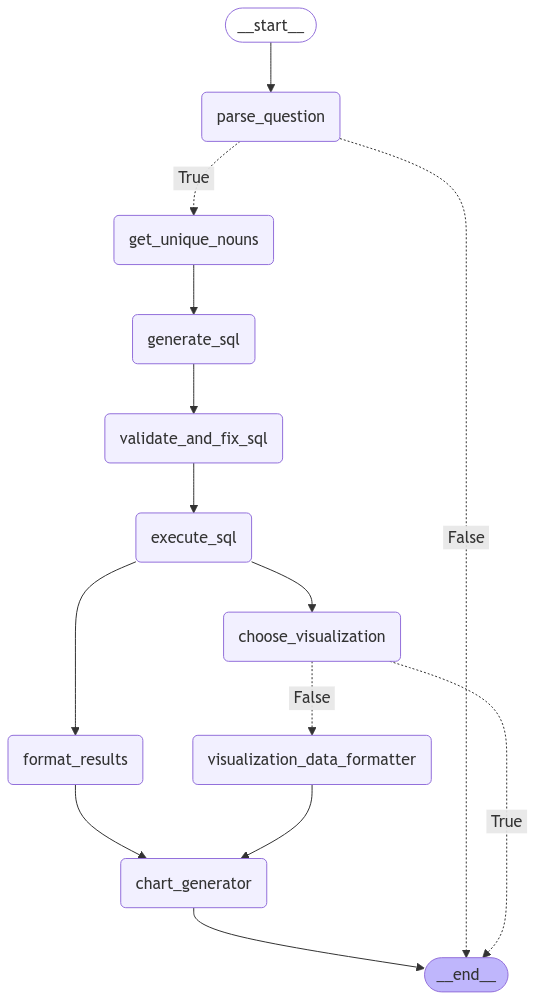

In [226]:
from IPython.display import Image, display
display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
stakeholder = "customer"

In [228]:
out = await runnable.ainvoke({
    "question": f"Top Insights provided by the customer.The table to look upon in Database belongs to stakeholder {stakeholder}",
    "diagnostic_id": "670c9d8043060aec0379fdd6",})

2025-02-10 19:58:06,620 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 19:58:06,625 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 19:58:06,630 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:06,882 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 19:58:06,885 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:07,131 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 19:58:07,134 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:07,383 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 19:58:07,386 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:07,633 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 19:58:07,638 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:07,884 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 19:58:07,886 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:08,134 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 19:58:08,136 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:08,384 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 19:58:08,386 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:08,633 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 19:58:08,636 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:08,883 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 19:58:08,886 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:09,133 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 19:58:09,136 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:09,384 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 19:58:09,388 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:09,637 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 19:58:09,639 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:09,889 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 19:58:09,892 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:10,139 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 19:58:10,142 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:10,389 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 19:58:10,391 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:10,640 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:10,642 INFO sqlalchemy.engine.Engine [cached since 3260s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3260s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 19:58:10,890 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:10,893 INFO sqlalchemy.engine.Engine [cached since 3261s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3261s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 19:58:11,141 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:11,144 INFO sqlalchemy.engine.Engine [cached since 3261s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3261s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 19:58:11,392 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:11,394 INFO sqlalchemy.engine.Engine [cached since 3261s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3261s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 19:58:11,643 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:11,646 INFO sqlalchemy.engine.Engine [cached since 3261s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3261s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 19:58:11,894 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:11,898 INFO sqlalchemy.engine.Engine [cached since 3262s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3262s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 19:58:12,148 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:12,151 INFO sqlalchemy.engine.Engine [cached since 3262s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3262s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 19:58:12,415 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'feedback', 'suggestions', 'testimonial_name', 'email', 'company_name', 'experience_sentiment']}]}
2025-02-10 19:58:16,440 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 19:58:16,444 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `feedback`, `suggestions`, `testimonial_name`, `email`, `company_name`, `experience_sentiment` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `feedback`, `suggestions`, `testimonial_name`, `email`, `company_name`, `experience_sentiment` FROM `customer_data`


2025-02-10 19:58:16,447 INFO sqlalchemy.engine.Engine [cached since 3255s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 3255s ago] ()


2025-02-10 19:58:16,941 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 19:58:17,432 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 19:58:17,435 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 19:58:17,438 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:17,686 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 19:58:17,689 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:17,938 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 19:58:17,940 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:18,188 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 19:58:18,190 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:18,437 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 19:58:18,439 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:18,686 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 19:58:18,688 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:18,936 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 19:58:18,939 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:19,188 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 19:58:19,191 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:19,440 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 19:58:19,443 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:19,691 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 19:58:19,694 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:19,944 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 19:58:19,946 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:20,194 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 19:58:20,198 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:20,445 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 19:58:20,448 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:20,695 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 19:58:20,698 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:20,945 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 19:58:20,948 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:21,195 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 19:58:21,198 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:21,447 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:21,450 INFO sqlalchemy.engine.Engine [cached since 3271s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3271s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 19:58:21,699 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:21,702 INFO sqlalchemy.engine.Engine [cached since 3271s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3271s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 19:58:21,955 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:21,958 INFO sqlalchemy.engine.Engine [cached since 3272s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3272s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 19:58:22,207 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:22,210 INFO sqlalchemy.engine.Engine [cached since 3272s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3272s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 19:58:22,458 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:22,461 INFO sqlalchemy.engine.Engine [cached since 3272s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3272s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 19:58:22,709 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:22,713 INFO sqlalchemy.engine.Engine [cached since 3272s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3272s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 19:58:22,963 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:22,966 INFO sqlalchemy.engine.Engine [cached since 3273s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3273s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 19:58:23,238 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 19:58:27,592 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 19:58:27,596 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 19:58:27,601 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:27,849 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 19:58:27,852 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:28,099 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 19:58:28,102 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:28,351 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 19:58:28,355 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:28,602 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 19:58:28,605 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:28,852 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 19:58:28,855 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:29,105 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 19:58:29,108 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:29,356 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 19:58:29,360 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:29,608 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 19:58:29,611 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:29,858 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 19:58:29,861 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:30,108 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 19:58:30,111 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:30,358 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 19:58:30,362 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:30,610 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 19:58:30,614 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:30,862 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 19:58:30,865 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:31,112 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 19:58:31,115 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:31,365 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 19:58:31,369 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 19:58:31,617 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:31,621 INFO sqlalchemy.engine.Engine [cached since 3281s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3281s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 19:58:31,869 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:31,872 INFO sqlalchemy.engine.Engine [cached since 3282s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3282s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 19:58:32,122 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:32,124 INFO sqlalchemy.engine.Engine [cached since 3282s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3282s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 19:58:32,373 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:32,378 INFO sqlalchemy.engine.Engine [cached since 3282s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3282s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 19:58:32,629 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:32,632 INFO sqlalchemy.engine.Engine [cached since 3282s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3282s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 19:58:32,882 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:32,886 INFO sqlalchemy.engine.Engine [cached since 3283s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3283s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 19:58:33,136 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 19:58:33,138 INFO sqlalchemy.engine.Engine [cached since 3283s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 3283s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 19:58:33,401 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 19:58:36,361 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 19:58:36,366 INFO sqlalchemy.engine.Engine SELECT `feedback`, `suggestions` FROM `customer_data` WHERE `diagnostic_id` = '670c9d8043060aec0379fdd6' AND (`feedback` IS NOT NULL AND `feedback` NOT IN ('', 'N/A')) AND (`suggestions` IS NOT NULL AND `suggestions` NOT IN ('', 'N/A')) ORDER BY `feedback`, `suggestions`;


INFO:sqlalchemy.engine.Engine:SELECT `feedback`, `suggestions` FROM `customer_data` WHERE `diagnostic_id` = '670c9d8043060aec0379fdd6' AND (`feedback` IS NOT NULL AND `feedback` NOT IN ('', 'N/A')) AND (`suggestions` IS NOT NULL AND `suggestions` NOT IN ('', 'N/A')) ORDER BY `feedback`, `suggestions`;


2025-02-10 19:58:36,371 INFO sqlalchemy.engine.Engine [generated in 0.00568s] ()


INFO:sqlalchemy.engine.Engine:[generated in 0.00568s] ()


2025-02-10 19:58:36,625 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


fr
cv
fre
cve


In [230]:
print(out["answer"])

The query results do not provide any meaningful insights related to the user's question about top insights provided by customers. The results only contain repeated tuples with the phrase "good boi", which does not seem relevant to the requested information.


In [ ]:
from pyngrok import ngrok

!ngrok authtoken ''

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install flask_cors

In [ ]:
from flask import Flask, request, jsonify
import asyncio
from pyngrok import ngrok
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

port = 6070
public_url = ngrok.connect(port, "http")
print(f"Public URL: {public_url}")

@app.route("/dashboardAgent", methods=["POST"])
def dashboard_agent():
    data = request.get_json()
    prompt = data.get("prompt")
    question = f"{prompt}.The table to look upon in Database belongs to stakeholder {stakeholder}"
    result = asyncio.run(runnable.ainvoke({"question": question, "diagnostic_id": "670d7bb908cd96a9c3b69aaf"}))
    return jsonify({"data":result["formatted_data_for_visualization"],"visualization":result["visualization"],"answer":result["answer"],"sql_query":result["sql_query"]})

app.run(port=port)


Public URL: NgrokTunnel: "https://11c3-34-16-175-19.ngrok-free.app" -> "http://localhost:6070"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:6070
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 14:56:27] "OPTIONS /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 14:56:27] "OPTIONS /dashboardAgent HTTP/1.1" 200 -


2025-02-10 14:56:28,025 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:56:28,034 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 14:56:28,040 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:28,048 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 14:56:29,338 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:56:29,341 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 14:56:29,345 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:29,596 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 14:56:29,600 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:29,847 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 14:56:29,849 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:30,098 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 14:56:30,101 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:30,349 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 14:56:30,352 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:30,603 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 14:56:30,607 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:30,855 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 14:56:30,857 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:31,117 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 14:56:31,120 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:31,368 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 14:56:31,371 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:31,622 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 14:56:31,626 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:31,874 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 14:56:31,878 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:32,128 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 14:56:32,134 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:32,383 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 14:56:32,386 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:32,636 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 14:56:32,641 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:32,889 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 14:56:32,892 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:33,141 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 14:56:33,145 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:33,397 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:33,400 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 14:56:33,651 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:33,653 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 14:56:33,903 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:33,906 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 14:56:34,155 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:34,158 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 14:56:34,407 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:34,410 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 14:56:34,659 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:34,661 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 14:56:34,912 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:34,915 INFO sqlalchemy.engine.Engine [cached since 1.821e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.821e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 14:56:35,179 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 14:56:44,977 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:56:44,980 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 14:56:44,983 INFO sqlalchemy.engine.Engine [cached since 1729s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1729s ago] ()


2025-02-10 14:56:45,471 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 14:56:45,955 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:56:45,958 INFO sqlalchemy.engine.Engine SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


2025-02-10 14:56:45,961 INFO sqlalchemy.engine.Engine [cached since 1729s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1729s ago] ()


2025-02-10 14:56:46,214 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 14:56:46,710 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:56:46,713 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 14:56:46,716 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:46,963 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 14:56:46,966 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:47,210 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 14:56:47,212 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:47,456 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 14:56:47,458 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:47,702 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 14:56:47,704 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:47,947 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 14:56:47,950 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:48,193 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 14:56:48,196 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:48,438 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 14:56:48,440 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:48,683 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 14:56:48,686 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:48,929 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 14:56:48,931 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:49,174 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 14:56:49,176 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:49,419 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 14:56:49,422 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:49,664 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 14:56:49,667 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:49,911 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 14:56:49,913 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:50,155 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 14:56:50,159 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:50,404 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 14:56:50,406 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:56:50,650 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:50,652 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 14:56:50,899 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:50,902 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 14:56:51,146 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:51,149 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 14:56:51,395 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:51,399 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 14:56:51,645 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:51,648 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 14:56:51,893 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:51,896 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 14:56:52,145 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:56:52,149 INFO sqlalchemy.engine.Engine [cached since 1.823e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.823e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 14:56:52,412 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 14:57:00,192 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:57:00,196 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 14:57:00,201 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:00,452 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 14:57:00,454 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:00,702 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 14:57:00,706 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:00,955 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 14:57:00,959 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:01,210 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 14:57:01,214 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:01,466 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 14:57:01,470 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:01,719 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 14:57:01,721 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:01,970 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 14:57:01,973 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:02,222 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 14:57:02,225 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:02,476 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 14:57:02,479 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:02,727 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 14:57:02,731 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:02,981 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 14:57:02,986 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:03,234 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 14:57:03,239 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:03,487 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 14:57:03,490 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:03,739 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 14:57:03,741 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:03,992 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 14:57:03,996 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 14:57:04,246 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:04,250 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 14:57:04,503 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:04,506 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 14:57:04,758 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:04,761 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 14:57:05,011 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:05,014 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 14:57:05,263 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:05,266 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 14:57:05,516 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:05,518 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 14:57:05,768 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 14:57:05,771 INFO sqlalchemy.engine.Engine [cached since 1.824e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.824e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 14:57:06,034 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 14:57:08,675 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 14:57:08,680 INFO sqlalchemy.engine.Engine SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


INFO:sqlalchemy.engine.Engine:SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


2025-02-10 14:57:08,683 INFO sqlalchemy.engine.Engine [cached since 1239s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1239s ago] ()


2025-02-10 14:57:08,927 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 14:57:13] "POST /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:00:05] "OPTIONS /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:00:05] "OPTIONS /dashboardAgent HTTP/1.1" 200 -


2025-02-10 15:00:06,139 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:06,144 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:00:06,149 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:06,153 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:00:06,206 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:06,212 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:00:06,218 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:06,222 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:00:37,264 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:37,269 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:00:37,274 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:37,336 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:37,340 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:00:37,343 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:37,519 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:00:37,522 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:37,588 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:00:37,591 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:37,766 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:00:37,769 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:37,834 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:00:37,837 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,013 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:00:38,017 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,080 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:00:38,083 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,262 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:00:38,265 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,328 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:00:38,333 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,511 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:00:38,515 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,576 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:00:38,581 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,760 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:00:38,764 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:38,825 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:00:38,828 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,008 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:00:39,012 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,072 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:00:39,075 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,259 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:00:39,261 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,317 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:00:39,320 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,505 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:00:39,509 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,563 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:00:39,566 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,754 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:00:39,758 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:39,808 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:00:39,811 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,006 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:00:40,010 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,053 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:00:40,056 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,255 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:00:40,259 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,302 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:00:40,305 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,504 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:00:40,506 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,547 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:00:40,550 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,749 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:00:40,752 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,792 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:00:40,795 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:40,996 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:00:40,998 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:41,038 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:00:41,040 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:00:41,243 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,245 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:00:41,283 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,288 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:00:41,490 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,494 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:00:41,532 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,535 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:00:41,739 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,742 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:00:41,781 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,783 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:00:41,988 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:41,990 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:00:42,027 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,030 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:00:42,235 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,238 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:00:42,276 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,279 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:00:42,486 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,490 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:00:42,524 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,527 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:00:42,736 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,738 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:00:42,772 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:00:42,775 INFO sqlalchemy.engine.Engine [cached since 1.846e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.846e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:00:42,997 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:00:43,034 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:00:48,508 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:48,513 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:00:48,517 INFO sqlalchemy.engine.Engine [cached since 1972s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1972s ago] ()


2025-02-10 15:00:48,523 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:00:49,275 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:00:49,280 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:00:49,284 INFO sqlalchemy.engine.Engine [cached since 1973s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1973s ago] ()


2025-02-10 15:00:49,287 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:01:20,905 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:20,908 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:20,912 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:20,940 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:20,944 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:20,947 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,162 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:21,164 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,192 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:21,194 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,409 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:21,413 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,437 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:21,440 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,656 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:21,659 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,683 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:21,685 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,901 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:21,904 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:21,928 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:21,931 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,146 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:22,149 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,174 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:22,176 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,392 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:22,397 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,420 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:22,423 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,640 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:22,643 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,666 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:22,669 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,887 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:22,889 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:22,913 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:22,916 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,133 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:23,135 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,160 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:23,162 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,377 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:23,380 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,405 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:23,407 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,623 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:23,626 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,651 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:23,654 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,870 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:23,872 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:23,898 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:23,900 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,114 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:24,117 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,143 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:24,146 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,362 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:24,365 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,390 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:24,393 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,608 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:24,612 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,635 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:24,639 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:24,855 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:24,858 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:24,884 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:24,886 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:25,105 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,107 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:25,132 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,136 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:25,352 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,356 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:25,382 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,384 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:25,601 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,606 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:25,632 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,636 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:25,850 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,852 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:25,883 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:25,886 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:26,097 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:26,100 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:26,131 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:26,134 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:26,346 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:26,349 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:26,383 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:26,386 INFO sqlalchemy.engine.Engine [cached since 1.85e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.85e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:26,611 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:26,660 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:01:31,385 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:31,389 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:01:31,393 INFO sqlalchemy.engine.Engine [cached since 2015s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2015s ago] ()


2025-02-10 15:01:31,879 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:01:32,015 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:32,019 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:01:32,020 INFO sqlalchemy.engine.Engine [cached since 2016s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2016s ago] ()


2025-02-10 15:01:32,361 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:32,363 INFO sqlalchemy.engine.Engine SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


2025-02-10 15:01:32,365 INFO sqlalchemy.engine.Engine [cached since 2015s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2015s ago] ()


2025-02-10 15:01:32,504 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:32,612 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:32,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:32,989 INFO sqlalchemy.engine.Engine SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `attribute_name`, `attribute_value` FROM `customer_demographics`


2025-02-10 15:01:32,991 INFO sqlalchemy.engine.Engine [cached since 2016s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2016s ago] ()


2025-02-10 15:01:33,095 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:33,097 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:33,103 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:33,239 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:33,349 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:33,352 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:33,597 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:33,600 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:33,721 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:33,724 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:33,726 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:33,842 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:33,845 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:33,970 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:33,973 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,087 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:34,090 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,217 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:34,220 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,334 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:34,337 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,463 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:34,466 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,579 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:34,582 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,710 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:34,713 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,825 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:34,829 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:34,955 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:34,958 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,071 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:35,074 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,201 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:35,204 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,317 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:35,320 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,448 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:35,451 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,564 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:35,567 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,694 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:35,698 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,811 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:35,814 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:35,942 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:35,945 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,057 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:36,059 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,188 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:36,192 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,302 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:36,305 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,437 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:36,440 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,547 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:36,550 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,686 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:36,689 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,794 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:36,798 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:36,932 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:36,934 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:37,042 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,045 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:37,177 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:37,180 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:37,290 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,293 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:37,423 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:37,426 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:37,538 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,541 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:37,671 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,673 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:37,786 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,788 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:37,919 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:37,921 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:38,031 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,034 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:38,171 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,173 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:38,278 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,281 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:38,418 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,421 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:38,525 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,528 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:38,668 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,670 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:38,793 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:38,914 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:38,918 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:39,163 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:39,166 INFO sqlalchemy.engine.Engine [cached since 1.851e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.851e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:39,433 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:44,478 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:44,481 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:44,484 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:44,730 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:44,734 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:44,948 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:44,953 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:01:44,958 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:44,976 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:44,980 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,203 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:01:45,206 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,223 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:45,227 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,448 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:01:45,451 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,469 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:45,472 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,694 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:01:45,697 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,715 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:45,718 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,940 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:01:45,943 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:45,962 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:45,964 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,186 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:01:46,189 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,206 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:46,209 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,431 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:01:46,433 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,450 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:46,452 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,675 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:01:46,678 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,694 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:46,698 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,920 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:01:46,922 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:46,945 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:46,947 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,164 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:01:47,167 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,189 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:47,191 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,408 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:01:47,411 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,433 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:47,435 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,653 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:01:47,655 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,677 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:47,681 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,897 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:01:47,902 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:47,923 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:47,927 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:48,152 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:01:48,155 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:48,172 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:48,175 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:48,400 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:01:48,403 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:48,419 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:48,422 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:48,646 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:01:48,649 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:01:48,667 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:48,671 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:48,892 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:48,895 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:01:48,914 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:48,918 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:49,139 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,142 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:01:49,162 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,166 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:49,386 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,389 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:01:49,410 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,414 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:49,636 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,638 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:01:49,657 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,660 INFO sqlalchemy.engine.Engine [cached since 1.852e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.852e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:49,883 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,886 INFO sqlalchemy.engine.Engine [cached since 1.853e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.853e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:01:49,903 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:49,905 INFO sqlalchemy.engine.Engine [cached since 1.853e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.853e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:50,132 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:50,135 INFO sqlalchemy.engine.Engine [cached since 1.853e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.853e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:01:50,173 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:50,380 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:01:50,383 INFO sqlalchemy.engine.Engine [cached since 1.853e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.853e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:01:50,887 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:52,877 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:52,880 INFO sqlalchemy.engine.Engine SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


INFO:sqlalchemy.engine.Engine:SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


2025-02-10 15:01:52,882 INFO sqlalchemy.engine.Engine [cached since 1524s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1524s ago] ()


2025-02-10 15:01:53,126 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:01:55,860 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:01:55,864 INFO sqlalchemy.engine.Engine SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


INFO:sqlalchemy.engine.Engine:SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%%location%%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670d7bb908cd96a9c3b69aaf') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;


2025-02-10 15:01:55,868 INFO sqlalchemy.engine.Engine [cached since 1527s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 1527s ago] ()


2025-02-10 15:01:56,110 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:01:59] "POST /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:01:59] "POST /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:02:52] "OPTIONS /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:03:10] "OPTIONS /dashboardAgent HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Feb/2025 15:03:10] "OPTIONS /dashboardAgent HTTP/1.1" 200 -


2025-02-10 15:03:10,853 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:10,858 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:10,862 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:10,866 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:03:10,998 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:11,008 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:11,011 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:11,013 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:03:29,320 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:29,324 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:29,332 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:29,335 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:29,338 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:29,349 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:29,576 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:03:29,578 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:29,592 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:03:29,596 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:29,821 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:03:29,824 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:29,838 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:03:29,840 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,067 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:03:30,071 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,083 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:03:30,087 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,314 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:03:30,318 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,330 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:03:30,334 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,564 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:03:30,567 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,578 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:03:30,583 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,811 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:03:30,815 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:30,827 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:03:30,829 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,062 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:03:31,065 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,076 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:03:31,079 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,309 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:03:31,312 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,324 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:03:31,327 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,555 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:03:31,558 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,570 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:03:31,573 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,805 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:03:31,809 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:31,818 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:03:31,820 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,054 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:03:32,056 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,062 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:03:32,067 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,299 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:03:32,302 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,313 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:03:32,315 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,548 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:03:32,550 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,558 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:03:32,562 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,795 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:03:32,800 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:32,804 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:03:32,808 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:33,042 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:03:33,045 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:33,050 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:03:33,052 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:33,290 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:33,296 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:33,297 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'candidate_data', 'id')
2025-02-10 15:03:33,302 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'candidate_data', 'id')
INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:03:33,553 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)
2025-02-10 15:03:33,554 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)
INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:33,559 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'csrpartner_data', 'id')
2025-02-10 15:03:33,562 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'csrpartner_data', 'id')
INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:03:33,807 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)
2025-02-10 15:03:33,810 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)
INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:33,813 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'customer_data', 'id')
2025-02-10 15:03:33,816 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'customer_data', 'id')
INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:03:34,066 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,070 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:03:34,073 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,077 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:03:34,313 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,316 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:03:34,323 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,327 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:03:34,559 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,562 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:03:34,573 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,575 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:03:34,807 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,810 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:03:34,819 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:03:34,822 INFO sqlalchemy.engine.Engine [cached since 1.863e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.863e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:03:35,075 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:03:35,085 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:03:39,975 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:39,984 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:03:39,987 INFO sqlalchemy.engine.Engine [cached since 2144s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2144s ago] ()


2025-02-10 15:03:39,989 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:03:40,537 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:40,540 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:03:40,545 INFO sqlalchemy.engine.Engine [cached since 2144s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2144s ago] ()


2025-02-10 15:03:40,550 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

2025-02-10 15:03:56,138 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:56,141 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:56,144 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,221 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:03:56,225 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM "defaultdb"


INFO:sqlalchemy.engine.Engine:SHOW FULL TABLES FROM "defaultdb"


2025-02-10 15:03:56,227 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,392 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:03:56,394 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,471 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "SequelizeMeta"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "SequelizeMeta"


2025-02-10 15:03:56,473 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,638 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:03:56,641 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,717 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_data"


2025-02-10 15:03:56,719 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,888 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:03:56,891 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:56,965 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "candidate_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "candidate_demographics"


2025-02-10 15:03:56,969 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,135 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:03:57,140 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,215 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_data"


2025-02-10 15:03:57,218 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,386 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:03:57,389 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,463 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "csrpartner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "csrpartner_demographics"


2025-02-10 15:03:57,466 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,635 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:03:57,638 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,712 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_data"


2025-02-10 15:03:57,715 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,883 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:03:57,887 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:57,960 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "customer_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "customer_demographics"


2025-02-10 15:03:57,963 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,130 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:03:58,133 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,207 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_data"


2025-02-10 15:03:58,210 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,378 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:03:58,381 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,455 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "employee_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "employee_demographics"


2025-02-10 15:03:58,458 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,626 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:03:58,630 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,702 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_data"


2025-02-10 15:03:58,705 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,876 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:03:58,878 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:58,949 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "investor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "investor_demographics"


2025-02-10 15:03:58,952 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,123 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:03:59,126 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,195 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_data"


2025-02-10 15:03:59,197 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,375 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:03:59,379 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,444 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "partner_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "partner_demographics"


2025-02-10 15:03:59,448 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,623 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:03:59,627 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,691 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_data"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_data"


2025-02-10 15:03:59,694 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,871 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:03:59,876 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:03:59,938 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE "vendor_demographics"


INFO:sqlalchemy.engine.Engine:SHOW CREATE TABLE "vendor_demographics"


2025-02-10 15:03:59,949 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2025-02-10 15:04:00,127 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,131 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:04:00,195 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,198 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'candidate_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'candidate_data', 'id')


2025-02-10 15:04:00,379 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,382 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:04:00,445 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,449 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'csrpartner_data', 'id')


2025-02-10 15:04:00,628 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,632 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:04:00,696 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,698 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'customer_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'customer_data', 'id')


2025-02-10 15:04:00,879 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,882 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:04:00,945 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:00,949 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'employee_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'employee_data', 'id')


2025-02-10 15:04:01,129 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,133 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:04:01,196 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,199 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'investor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'investor_data', 'id')


2025-02-10 15:04:01,381 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,384 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:04:01,445 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,448 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'partner_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'partner_data', 'id')


2025-02-10 15:04:01,640 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,643 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:04:01,695 INFO sqlalchemy.engine.Engine SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


INFO:sqlalchemy.engine.Engine:SELECT information_schema.columns.table_schema, information_schema.columns.table_name, information_schema.columns.column_name 
FROM information_schema.columns 
WHERE information_schema.columns.table_schema = %s AND information_schema.columns.table_name = %s AND lower(information_schema.columns.column_name) IN (%s)


2025-02-10 15:04:01,697 INFO sqlalchemy.engine.Engine [cached since 1.866e+04s ago] ('defaultdb', 'vendor_data', 'id')


INFO:sqlalchemy.engine.Engine:[cached since 1.866e+04s ago] ('defaultdb', 'vendor_data', 'id')


2025-02-10 15:04:01,903 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2025-02-10 15:04:01,956 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:04:06,794 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:04:06,797 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:04:06,802 INFO sqlalchemy.engine.Engine [cached since 2171s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2171s ago] ()


2025-02-10 15:04:06,805 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa

response {'is_relevant': True, 'relevant_tables': [{'table_name': 'customer_data', 'columns': ['id', 'created_at', 'updated_at', 'stakeholder_type', 'product_name', 'po_number', 'client_admin_ref', 'diagnostic_id', 'language', 'experience_rating', 'experience_type', 'experience_area', 'experience_area_dimension', 'feedback', 'sentiment_normalized_rating', 'suggestions', 'testimonial_consent', 'testimonial_name_consent', 'testimonial_name', 'email', 'company_name', 'channel', 'experience_sentiment'], 'noun_columns': ['product_name', 'language', 'experience_type', 'experience_area', 'experience_area_dimension', 'testimonial_name', 'email', 'company_name', 'channel']}, {'table_name': 'customer_demographics', 'columns': ['id', 'ref_id', 'attribute_name', 'attribute_value', 'stakeholder'], 'noun_columns': ['attribute_name', 'attribute_value']}]}
2025-02-10 15:04:07,729 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2025-02-10 15:04:07,732 INFO sqlalchemy.engine.Engine SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


INFO:sqlalchemy.engine.Engine:SELECT DISTINCT `product_name`, `language`, `experience_type`, `experience_area`, `experience_area_dimension`, `testimonial_name`, `email`, `company_name`, `channel` FROM `customer_data`


2025-02-10 15:04:07,734 INFO sqlalchemy.engine.Engine [cached since 2172s ago] ()


INFO:sqlalchemy.engine.Engine:[cached since 2172s ago] ()


2025-02-10 15:04:07,738 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK
ERROR:sqlalchemy.pool.impl.AsyncAdaptedQueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 986, in _finalize_fairy
    fairy._reset(
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/pool/base.py", line 1432, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/engine/default.py", line 700, in do_rollback
    dbapi_connection.rollback()
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/dialects/mysql/aiomysql.py", line 203, in rollback
    self.await_(self._connection.rollback())
  File "/usr/local/lib/python3.11/dist-packages/sqlalchemy/util/_concurrency_py3k.py", line 132, in await_only
    return current.parent.switch(awaitable)  # type: ignore[no-any-return,attr-defined] # noqa: E501
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packa